Import used libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

/Users/Malte/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Google SV and Bitcoin WAV in USD

Import used data:

In [2]:
bitcoin_weekly_volume = pd.DataFrame.from_csv("Bitcoin Weekly Volume Data USD.csv")
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume.csv")

## Calculate first log differences

In [3]:
bitcoin_weekly_volume_series = pd.Series(data=bitcoin_weekly_volume["Average Volume per Week"])
bitcoin_weekly_volume_series.head()

0    1.815588e+06
1    1.770383e+06
2    1.770067e+06
3    1.154001e+06
4    8.223102e+05
Name: Average Volume per Week, dtype: float64

In [4]:
bitcoin_weekly_volume_series_log = bitcoin_weekly_volume_series.apply(np.log)
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log.diff()
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log_diff.drop(0)
bitcoin_weekly_volume_series_log_diff.head()

1   -0.025213
2   -0.000179
3   -0.427782
4   -0.338873
5    0.033076
Name: Average Volume per Week, dtype: float64

In [5]:
google_queries_series = pd.Series(data=google_queries["Relative Search Volume"])
google_queries_series.head()

0    6
1    3
2    3
3    2
4    3
Name: Relative Search Volume, dtype: int64

In [6]:
google_queries_series_log = google_queries_series.apply(np.log)
google_queries_series_log_diff = google_queries_series_log.diff()
google_queries_series_log_diff = google_queries_series_log_diff.drop(0)
google_queries_series_log_diff.head()

1   -0.693147
2    0.000000
3   -0.405465
4    0.405465
5   -0.405465
Name: Relative Search Volume, dtype: float64

Join the two dataframes:

In [7]:
a = {'Date': bitcoin_weekly_volume["Date"] , 'Bitcoin WAV': bitcoin_weekly_volume_series_log_diff, "Google SV" : google_queries_series_log_diff}

In [8]:
google_queries_log_diff_and_bitcoin_volume_log_diff = pd.DataFrame(a)
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.drop(0)
google_queries_log_diff_and_bitcoin_volume_log_diff["Date"] = pd.to_datetime(google_queries_log_diff_and_bitcoin_volume_log_diff["Date"])
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.set_index("Date")
google_queries_log_diff_and_bitcoin_volume_log_diff.head()

,Bitcoin WAV,Google SV
Date,,
2013-04-21,-0.025213,-0.693147
2013-04-28,-0.000179,0.000000
2013-05-05,-0.427782,-0.405465
2013-05-12,-0.338873,0.405465
2013-05-19,0.033076,-0.405465


## Create the VAR Model

In [9]:
data_1 = google_queries_log_diff_and_bitcoin_volume_log_diff

In [10]:
model_1 = VAR(data_1)

## Lag order selection

In [11]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -4.527       -4.498      0.01082       -4.515
1        -4.637      -4.551*     0.009690      -4.602*
2       -4.654*       -4.511    0.009524*       -4.596
3        -4.642       -4.442     0.009636       -4.562
4        -4.645       -4.387     0.009614       -4.541
5        -4.627       -4.312     0.009789       -4.500
6        -4.638       -4.266     0.009681       -4.488
7        -4.650       -4.221     0.009565       -4.477
8        -4.631       -4.145     0.009749       -4.435
9        -4.617       -4.074     0.009892       -4.398
10       -4.605       -4.005      0.01001       -4.363
11       -4.574       -3.916      0.01033       -4.309
12       -4.562       -3.848      0.01045       -4.274
13       -4.543       -3.772      0.01066       -4.232
14       -4.521       -3.692      0.01090       -4.188
15       -

{'aic': 2, 'bic': 1, 'fpe': 2, 'hqic': 1}

In [12]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

Check coefficients, contemporaneous correlation of residuals etc.

In [13]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.53746
Nobs:                     259.000    HQIC:                  -4.58673
Log likelihood:          -130.739    FPE:                 0.00985422
AIC:                     -4.61986    Det(Omega_mle):      0.00962985
--------------------------------------------------------------------
Results for equation Bitcoin WAV
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.018532         0.027446            0.675           0.500
L1.Bitcoin WAV        -0.259027         0.069838           -3.709           0.000
L1.Google SV           0.019526         0.118185  

## Impulse Response Analysis

In [14]:
irf_1 = results_1.irf(5)

Without orthogonalization:

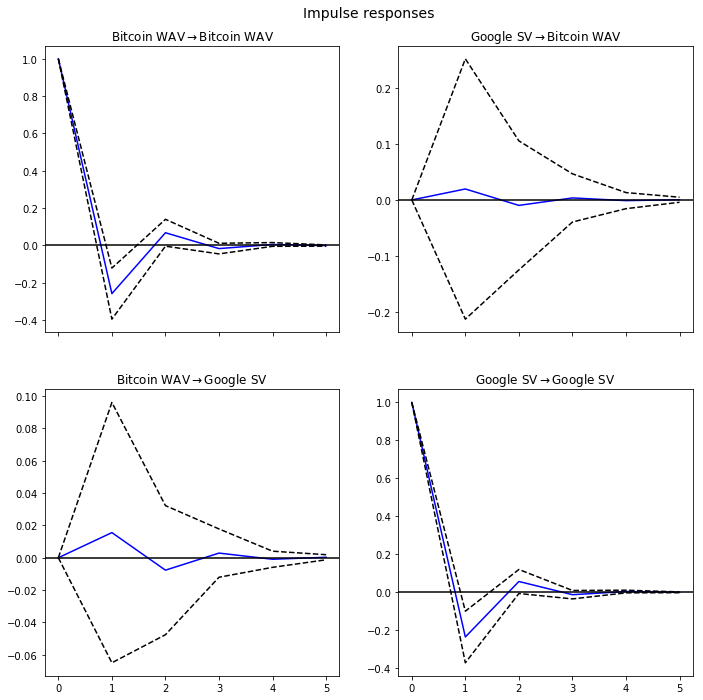

In [15]:
irf_1.plot()
plt.show()

With orthogonalization: Order: Bitcoin WAV - Google SV

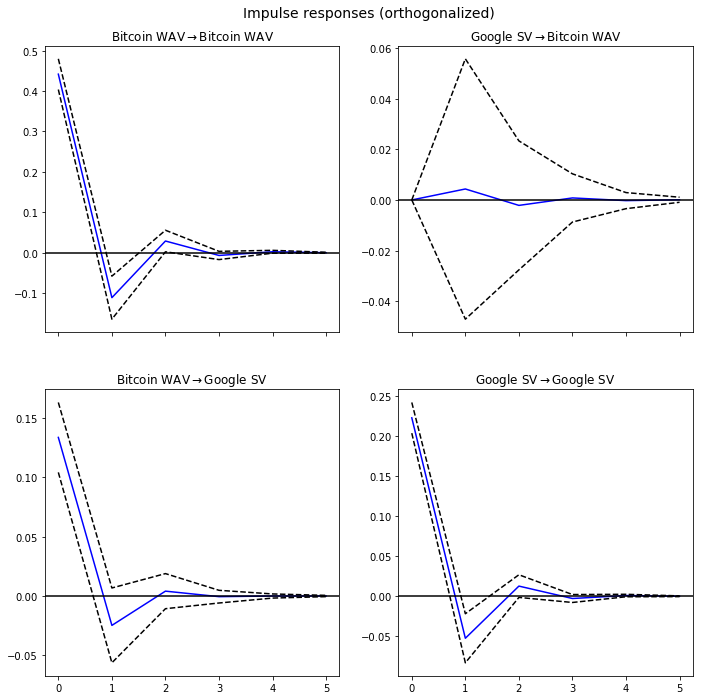

In [16]:
irf_1.plot(orth=True)
plt.show()

With orthogonalization: Order: Google SV - Bitcoin WAV

In [17]:
cols = google_queries_log_diff_and_bitcoin_volume_log_diff.columns.tolist()
cols

['Bitcoin WAV', 'Google SV']

In [18]:
cols = cols[-1:] + cols[:-1]
cols

['Google SV', 'Bitcoin WAV']

In [19]:
google_queries_log_diff_and_bitcoin_volume_log_diff_b = google_queries_log_diff_and_bitcoin_volume_log_diff[cols]
google_queries_log_diff_and_bitcoin_volume_log_diff_b.head()

,Google SV,Bitcoin WAV
Date,,
2013-04-21,-0.693147,-0.025213
2013-04-28,0.000000,-0.000179
2013-05-05,-0.405465,-0.427782
2013-05-12,0.405465,-0.338873
2013-05-19,-0.405465,0.033076


In [20]:
data_1_b = google_queries_log_diff_and_bitcoin_volume_log_diff_b
model_1_b = VAR(data_1_b)

In [21]:
results_1_b = model_1_b.fit(maxlags=15, ic='bic')

In [22]:
results_1_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.53746
Nobs:                     259.000    HQIC:                  -4.58673
Log likelihood:          -130.739    FPE:                 0.00985422
AIC:                     -4.61986    Det(Omega_mle):      0.00962985
--------------------------------------------------------------------
Results for equation Google SV
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.006264         0.016119            0.389           0.698
L1.Google SV          -0.236380         0.069409           -3.406           0.001
L1.Bitcoin WAV         0.015507         0.041015    

In [23]:
irf_1_b = results_1_b.irf(5)

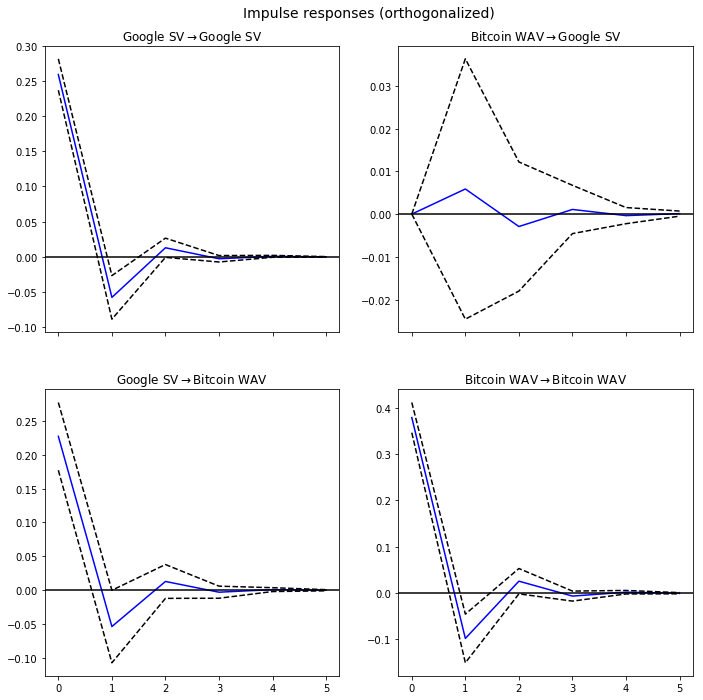

In [24]:
irf_1_b.plot(orth=True)
plt.show()

## Granger Causality Test

In [25]:
results_1.test_causality("Bitcoin WAV", "Google SV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.027298         3.859685            0.869  (1, 512)
H_0: ['Google SV'] do not Granger-cause Bitcoin WAV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.86883615071632503,
 'signif': 0.05,
 'statistic': 0.027297600508870343}

In [26]:
results_1.test_causality("Google SV", "Bitcoin WAV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.142936         3.859685            0.706  (1, 512)
H_0: ['Bitcoin WAV'] do not Granger-cause Google SV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.70553657581621454,
 'signif': 0.05,
 'statistic': 0.14293561096703297}

# 2. Google SV and Bitcoin WAV in BTC

Import used data:

In [27]:
bitcoin_weekly_volume = pd.DataFrame.from_csv("Bitcoin Weekly Volume Data BTC.csv")
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume.csv")

## Calculate first log differences

In [28]:
bitcoin_weekly_volume_series = pd.Series(data=bitcoin_weekly_volume["Average Volume per Week (BTC)"])
bitcoin_weekly_volume_series.head()

0    20202.562639
1    13204.207000
2    15670.144724
3    10198.091312
4     7279.517695
Name: Average Volume per Week (BTC), dtype: float64

In [29]:
bitcoin_weekly_volume_series_log = bitcoin_weekly_volume_series.apply(np.log)
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log.diff()
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log_diff.drop(0)
bitcoin_weekly_volume_series_log_diff.head()

1   -0.425274
2    0.171222
3   -0.429557
4   -0.337136
5   -0.042699
Name: Average Volume per Week (BTC), dtype: float64

In [30]:
google_queries_series = pd.Series(data=google_queries["Relative Search Volume"])
google_queries_series.head()

0    6
1    3
2    3
3    2
4    3
Name: Relative Search Volume, dtype: int64

In [31]:
google_queries_series_log = google_queries_series.apply(np.log)
google_queries_series_log_diff = google_queries_series_log.diff()
google_queries_series_log_diff = google_queries_series_log_diff.drop(0)
google_queries_series_log_diff.head()

1   -0.693147
2    0.000000
3   -0.405465
4    0.405465
5   -0.405465
Name: Relative Search Volume, dtype: float64

Join the two dataframes:

In [32]:
a = {'Date': bitcoin_weekly_volume["Date"] , 'Bitcoin WAV': bitcoin_weekly_volume_series_log_diff, "Google SV" : google_queries_series_log_diff}

In [33]:
google_queries_log_diff_and_bitcoin_volume_log_diff = pd.DataFrame(a)
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.drop(0)
google_queries_log_diff_and_bitcoin_volume_log_diff["Date"] = pd.to_datetime(google_queries_log_diff_and_bitcoin_volume_log_diff["Date"])
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.set_index("Date")
google_queries_log_diff_and_bitcoin_volume_log_diff.head()

,Bitcoin WAV,Google SV
Date,,
2013-04-21,-0.425274,-0.693147
2013-04-28,0.171222,0.000000
2013-05-05,-0.429557,-0.405465
2013-05-12,-0.337136,0.405465
2013-05-19,-0.042699,-0.405465


## Create the VAR Model

In [34]:
data_1 = google_queries_log_diff_and_bitcoin_volume_log_diff

In [35]:
model_1 = VAR(data_1)

## Lag order selection

In [36]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -4.492       -4.463      0.01120       -4.481
1       -4.603*      -4.517*     0.01003*      -4.568*
2        -4.597       -4.454      0.01008       -4.540
3        -4.584       -4.384      0.01021       -4.503
4        -4.585       -4.328      0.01020       -4.482
5        -4.566       -4.251      0.01041       -4.439
6        -4.582       -4.210      0.01024       -4.432
7        -4.586       -4.157      0.01020       -4.413
8        -4.580       -4.094      0.01026       -4.384
9        -4.559       -4.016      0.01048       -4.340
10       -4.552       -3.951      0.01056       -4.310
11       -4.519       -3.862      0.01091       -4.255
12       -4.498       -3.784      0.01114       -4.211
13       -4.481       -3.710      0.01134       -4.171
14       -4.463       -3.634      0.01155       -4.129
15       -

{'aic': 1, 'bic': 1, 'fpe': 1, 'hqic': 1}

In [37]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

Check coefficients, contemporaneous correlation of residuals etc.

In [38]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.49867
Nobs:                     259.000    HQIC:                  -4.54793
Log likelihood:          -135.762    FPE:                  0.0102440
AIC:                     -4.58106    Det(Omega_mle):       0.0100108
--------------------------------------------------------------------
Results for equation Bitcoin WAV
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.001142         0.026937           -0.042           0.966
L1.Bitcoin WAV        -0.286287         0.067491           -4.242           0.000
L1.Google SV          -0.050559         0.113962  

## Impulse Response Analysis

In [39]:
irf_1 = results_1.irf(5)

Without orthogonalization:

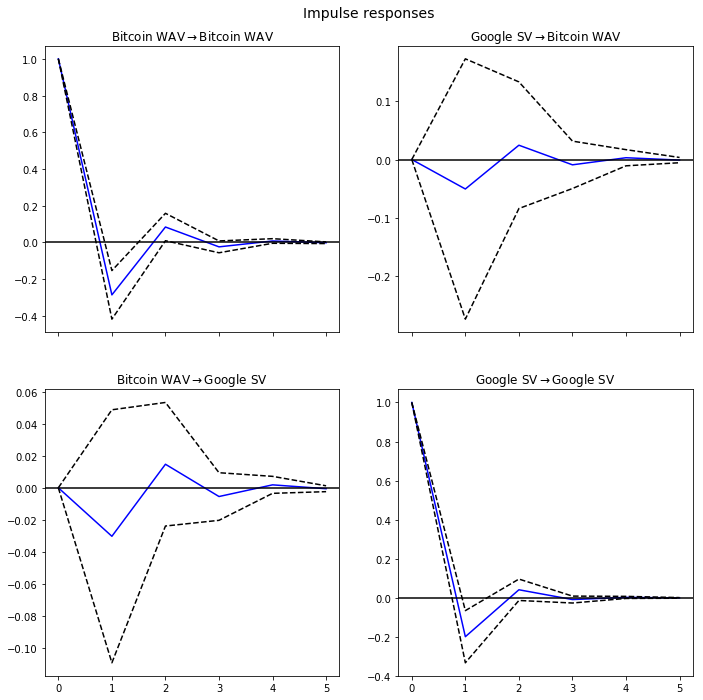

In [40]:
irf_1.plot()
plt.show()

With orthogonalization: Order: Bitcoin WAV - Google SV

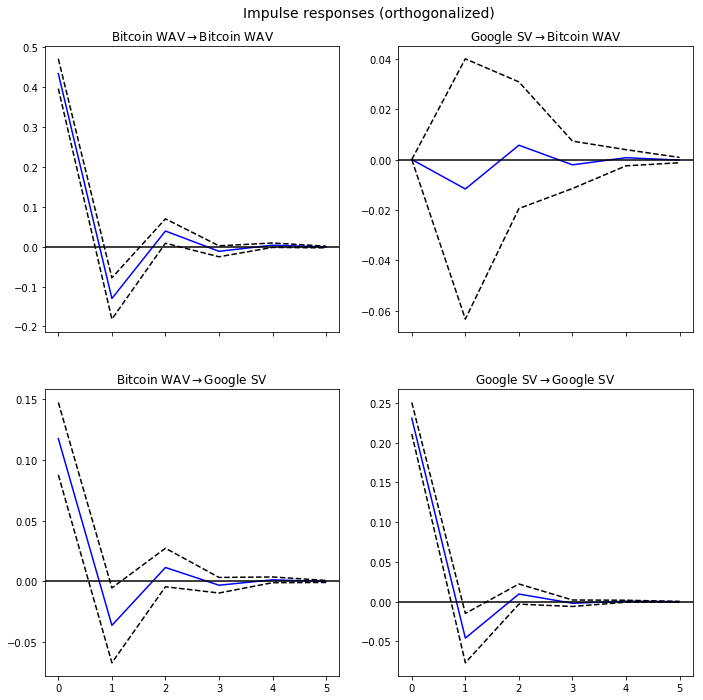

In [41]:
irf_1.plot(orth=True)
plt.show()

With orthogonalization: Order: Google SV - Bitcoin WAV

In [42]:
cols = google_queries_log_diff_and_bitcoin_volume_log_diff.columns.tolist()
cols

['Bitcoin WAV', 'Google SV']

In [43]:
cols = cols[-1:] + cols[:-1]
cols

['Google SV', 'Bitcoin WAV']

In [44]:
google_queries_log_diff_and_bitcoin_volume_log_diff_b = google_queries_log_diff_and_bitcoin_volume_log_diff[cols]
google_queries_log_diff_and_bitcoin_volume_log_diff_b.head()

,Google SV,Bitcoin WAV
Date,,
2013-04-21,-0.693147,-0.425274
2013-04-28,0.000000,0.171222
2013-05-05,-0.405465,-0.429557
2013-05-12,0.405465,-0.337136
2013-05-19,-0.405465,-0.042699


In [45]:
data_1_b = google_queries_log_diff_and_bitcoin_volume_log_diff_b
model_1_b = VAR(data_1_b)

In [46]:
results_1_b = model_1_b.fit(maxlags=15, ic='bic')

In [47]:
results_1_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.49867
Nobs:                     259.000    HQIC:                  -4.54793
Log likelihood:          -135.762    FPE:                  0.0102440
AIC:                     -4.58106    Det(Omega_mle):       0.0100108
--------------------------------------------------------------------
Results for equation Google SV
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.006315         0.016099            0.392           0.695
L1.Google SV          -0.199101         0.068108           -2.923           0.004
L1.Bitcoin WAV        -0.030313         0.040335    

In [48]:
irf_1_b = results_1_b.irf(5)

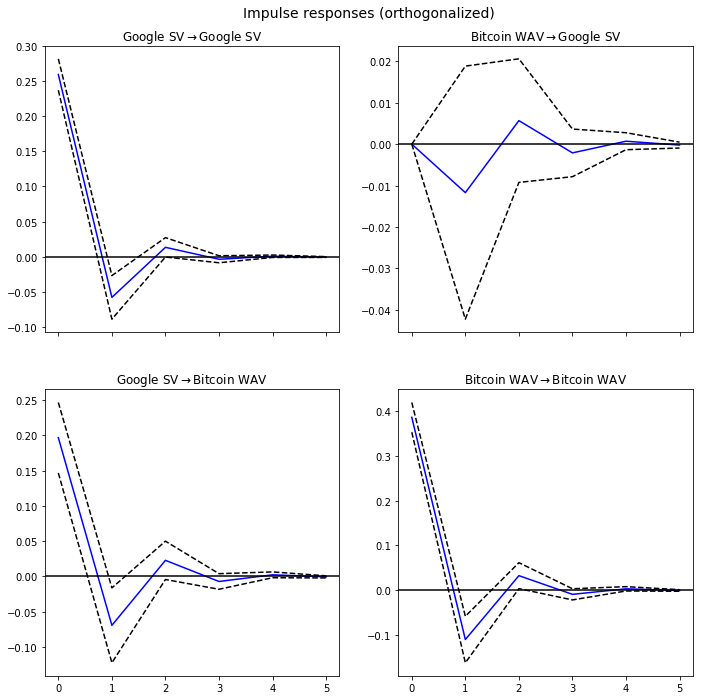

In [49]:
irf_1_b.plot(orth=True)
plt.show()

## Granger Causality Test

In [50]:
results_1.test_causality("Bitcoin WAV", "Google SV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.196826         3.859685            0.657  (1, 512)
H_0: ['Google SV'] do not Granger-cause Bitcoin WAV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.65748253067385476,
 'signif': 0.05,
 'statistic': 0.1968259850522146}

In [51]:
results_1.test_causality("Google SV", "Bitcoin WAV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.564785         3.859685            0.453  (1, 512)
H_0: ['Bitcoin WAV'] do not Granger-cause Google SV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.45268406159201302,
 'signif': 0.05,
 'statistic': 0.56478482370666017}

# 2. Wikipedia PV and Bitcoin DV in USD

Import used data:

In [52]:
bitcoin_daily_volume = pd.DataFrame.from_csv("Bitcoin Daily Volume Data USD.csv")
wikipedia_pageviews = pd.DataFrame.from_csv("Wikipedia Pageview Data.csv")

## Calculate first log differences

In [53]:
bitcoin_daily_volume_series = pd.Series(data=bitcoin_daily_volume["Volume (Currency)"])
bitcoin_daily_volume_series.head()

0    3.453026e+06
1    2.515779e+06
2    2.331332e+06
3    2.037201e+06
4    5.689203e+06
Name: Volume (Currency), dtype: float64

In [54]:
bitcoin_daily_volume_series_log = bitcoin_daily_volume_series.apply(np.log)
bitcoin_daily_volume_series_log_diff = bitcoin_daily_volume_series_log.diff()
bitcoin_daily_volume_series_log_diff = bitcoin_daily_volume_series_log_diff.drop(0)
bitcoin_daily_volume_series_log_diff.head()

1   -0.316669
2   -0.076143
3   -0.134863
4    1.026993
5   -0.038691
Name: Volume (Currency), dtype: float64

In [55]:
wikipedia_pageviews_series = pd.Series(data=wikipedia_pageviews["Pageviews"])
wikipedia_pageviews_series.head()

0    12957
1     9802
2     8307
3     8947
4     8692
Name: Pageviews, dtype: int64

In [56]:
wikipedia_pageviews_series_log = wikipedia_pageviews_series.apply(np.log)
wikipedia_pageviews_series_log_diff = wikipedia_pageviews_series_log.diff()
wikipedia_pageviews_series_log_diff = wikipedia_pageviews_series_log_diff.drop(0)
wikipedia_pageviews_series_log_diff.head()

1   -0.279050
2   -0.165488
3    0.074220
4   -0.028915
5    0.166142
Name: Pageviews, dtype: float64

Join the two dataframes:

In [57]:
b = {'Date': bitcoin_daily_volume["Date"] , 'Bitcoin DV (USD)': bitcoin_daily_volume_series_log_diff, "Wikipedia PV" : wikipedia_pageviews_series_log_diff}

In [58]:
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff = pd.DataFrame(b)
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.drop(0)
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff["Date"] = pd.to_datetime(wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff["Date"])
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.set_index("Date")
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.head()

,Bitcoin DV (USD),Wikipedia PV
Date,,
2015-07-02,-0.316669,-0.279050
2015-07-03,-0.076143,-0.165488
2015-07-04,-0.134863,0.074220
2015-07-05,1.026993,-0.028915
2015-07-06,-0.038691,0.166142


## Create the VAR Model

In [59]:
data_2 = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff

In [60]:
model_2 = VAR(data_2)

## Lag order selection

In [61]:
model_2.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -4.162       -4.153      0.01557       -4.159
1        -4.262       -4.233      0.01409       -4.251
2        -4.388       -4.339      0.01242       -4.370
3        -4.442       -4.373      0.01178       -4.416
4        -4.484       -4.395      0.01129       -4.450
5        -4.583       -4.475      0.01022       -4.542
6        -4.622      -4.494*     0.009838       -4.573
7        -4.630       -4.483     0.009757       -4.574
8        -4.638       -4.472     0.009676      -4.575*
9        -4.633       -4.447     0.009729       -4.562
10       -4.629       -4.423     0.009767       -4.551
11       -4.632       -4.407     0.009738       -4.546
12       -4.641       -4.397     0.009644       -4.548
13       -4.644       -4.380     0.009620       -4.543
14      -4.661*       -4.377    0.009454*       -4.553
15       -

{'aic': 14, 'bic': 6, 'fpe': 14, 'hqic': 8}

In [62]:
results_2 = model_2.fit(maxlags=15, ic='bic')

## Regression Results

Check coefficients, contemporaneous correlation of residuals etc.

In [63]:
results_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.49909
Nobs:                     1012.00    HQIC:                  -4.57747
Log likelihood:          -505.438    FPE:                 0.00979897
AIC:                     -4.62548    Det(Omega_mle):      0.00955199
--------------------------------------------------------------------
Results for equation Bitcoin DV (USD)
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.009247         0.014395            0.642           0.521
L1.Bitcoin DV (USD)        -0.494975         0.032356          -15.298           0.000
L1.Wikipedia PV          

## Impulse Response Analysis

In [64]:
irf_2 = results_2.irf(22)

Without orthogonalization:

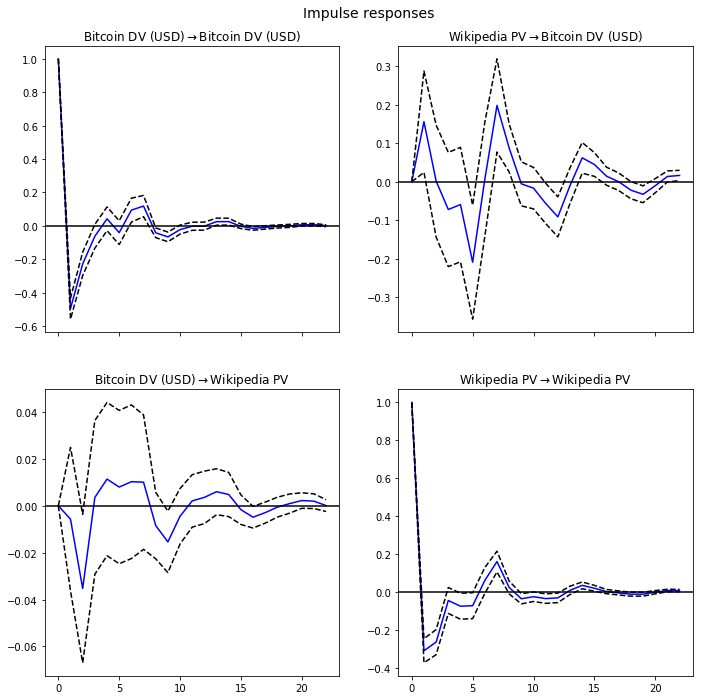

In [65]:
irf_2.plot()
plt.show()

With orthogonalization: Order: Bitcoin DV - Wikipedia PV

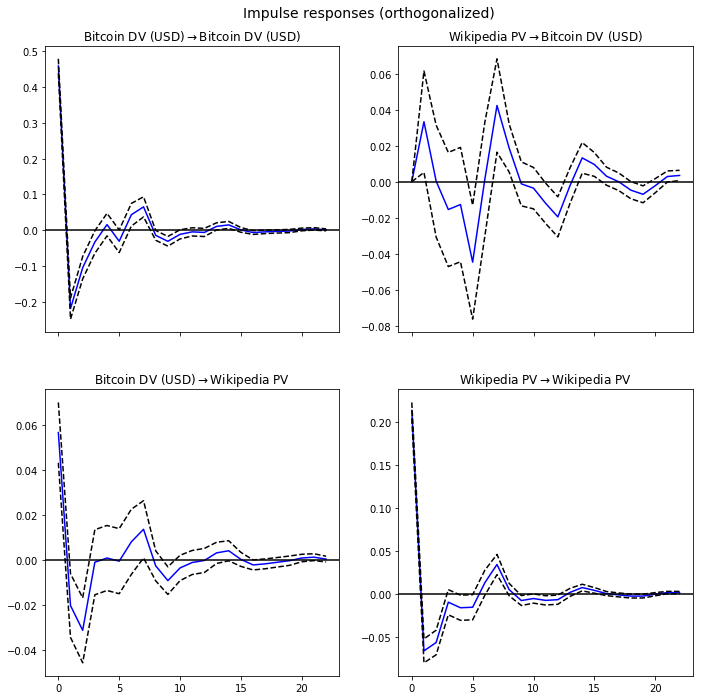

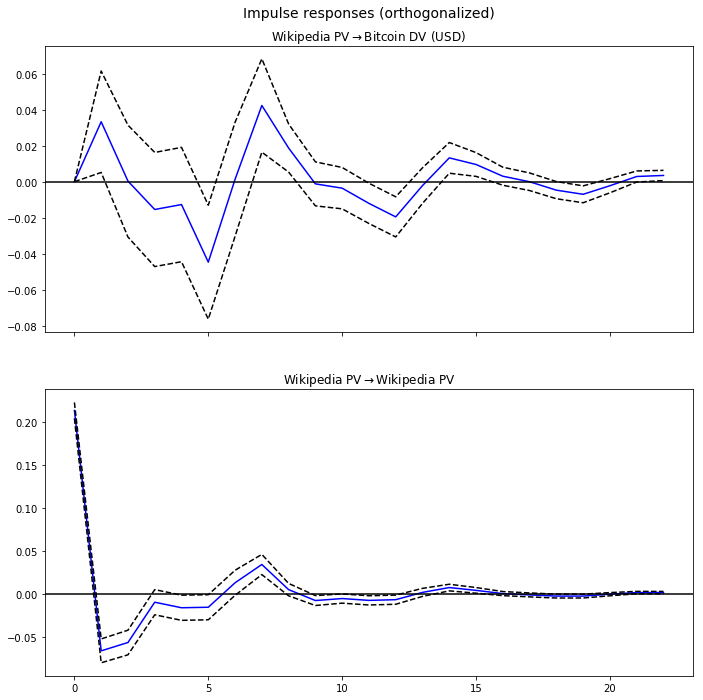

In [66]:
irf_2.plot(orth=True)
irf_2.plot(orth=True, impulse="Wikipedia PV")
plt.show()

With orthogonalisation: Order: Wikipedia PV - Bitcoin DV

In [67]:
cols_2 = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.columns.tolist()
cols_2

['Bitcoin DV (USD)', 'Wikipedia PV']

In [68]:
cols_2 = cols_2[-1:] + cols_2[:-1]
cols_2

['Wikipedia PV', 'Bitcoin DV (USD)']

In [69]:
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff_b = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff[cols_2]
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff_b.head()

,Wikipedia PV,Bitcoin DV (USD)
Date,,
2015-07-02,-0.279050,-0.316669
2015-07-03,-0.165488,-0.076143
2015-07-04,0.074220,-0.134863
2015-07-05,-0.028915,1.026993
2015-07-06,0.166142,-0.038691


In [70]:
data_2_b = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff_b
model_2_b = VAR(data_2_b)

In [71]:
results_2_b = model_2_b.fit(maxlags=15, ic='bic')

In [72]:
results_2_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.49909
Nobs:                     1012.00    HQIC:                  -4.57747
Log likelihood:          -505.438    FPE:                 0.00979897
AIC:                     -4.62548    Det(Omega_mle):      0.00955199
--------------------------------------------------------------------
Results for equation Wikipedia PV
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.001289         0.006946            0.186           0.853
L1.Wikipedia PV            -0.310567         0.032452           -9.570           0.000
L1.Bitcoin DV (USD)        -0

In [73]:
irf_2_b = results_2_b.irf(22)

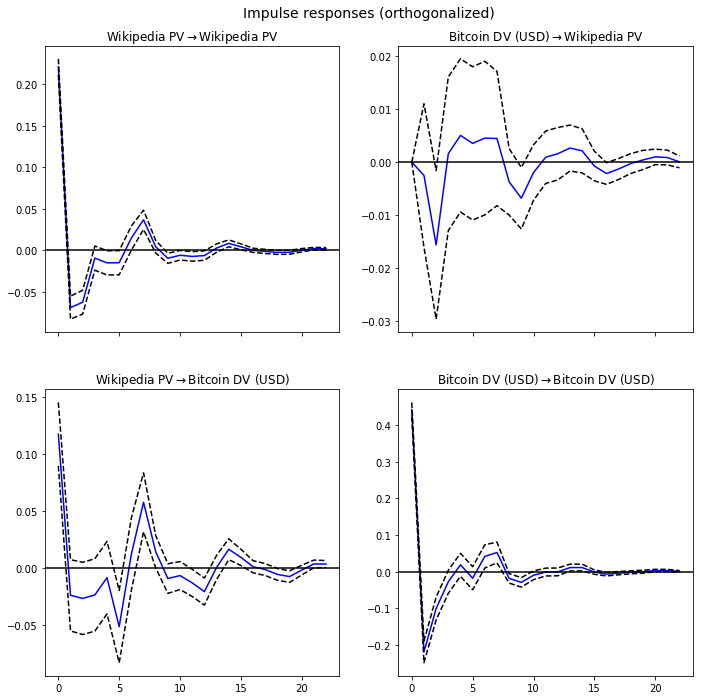

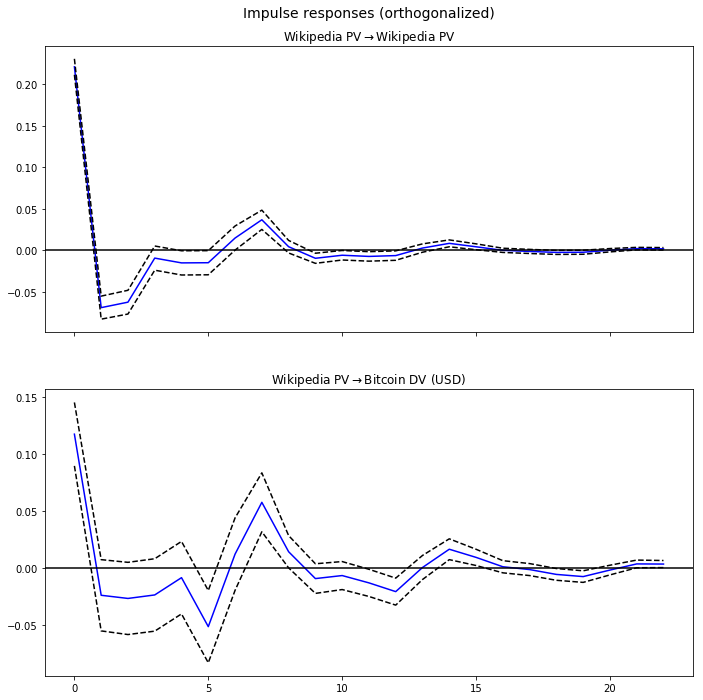

In [74]:
irf_2_b.plot(orth=True)
irf_2_b.plot(orth=True, impulse="Wikipedia PV")
plt.show()

## Granger Causality Test

In [75]:
results_2.test_causality("Bitcoin DV (USD)", "Wikipedia PV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         3.846549         2.103115            0.001  (6, 1998)
H_0: ['Wikipedia PV'] do not Granger-cause Bitcoin DV (USD)
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.00080660473721502833,
 'signif': 0.05,
 'statistic': 3.8465486672269424}

In [76]:
results_2.test_causality("Wikipedia PV", "Bitcoin DV (USD)", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.158596         2.103115            0.326  (6, 1998)
H_0: ['Bitcoin DV (USD)'] do not Granger-cause Wikipedia PV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.32582781976268865,
 'signif': 0.05,
 'statistic': 1.1585956570317897}

# 4. Wikipedia PV and Bitcoin DV in BTC

Import used data:

In [77]:
bitcoin_daily_volume = pd.DataFrame.from_csv("Bitcoin Daily Volume Data BTC.csv")
wikipedia_pageviews = pd.DataFrame.from_csv("Wikipedia Pageview Data.csv")

## Calculate first log differences

In [78]:
bitcoin_daily_volume_series = pd.Series(data=bitcoin_daily_volume["Volume (BTC)"])
bitcoin_daily_volume_series.head()

0    13395.153439
1     9826.994781
2     9153.852565
3     7909.856729
4    21362.613650
Name: Volume (BTC), dtype: float64

In [79]:
bitcoin_daily_volume_series_log = bitcoin_daily_volume_series.apply(np.log)
bitcoin_daily_volume_series_log_diff = bitcoin_daily_volume_series_log.diff()
bitcoin_daily_volume_series_log_diff = bitcoin_daily_volume_series_log_diff.drop(0)
bitcoin_daily_volume_series_log_diff.head()

1   -0.309760
2   -0.070958
3   -0.146065
4    0.993533
5   -0.064518
Name: Volume (BTC), dtype: float64

In [80]:
wikipedia_pageviews_series = pd.Series(data=wikipedia_pageviews["Pageviews"])
wikipedia_pageviews_series.head()

0    12957
1     9802
2     8307
3     8947
4     8692
Name: Pageviews, dtype: int64

In [81]:
wikipedia_pageviews_series_log = wikipedia_pageviews_series.apply(np.log)
wikipedia_pageviews_series_log_diff = wikipedia_pageviews_series_log.diff()
wikipedia_pageviews_series_log_diff = wikipedia_pageviews_series_log_diff.drop(0)
wikipedia_pageviews_series_log_diff.head()

1   -0.279050
2   -0.165488
3    0.074220
4   -0.028915
5    0.166142
Name: Pageviews, dtype: float64

Join the two dataframes:

In [82]:
b = {'Date': bitcoin_daily_volume["Date"] , 'Bitcoin DV': bitcoin_daily_volume_series_log_diff, "Wikipedia PV" : wikipedia_pageviews_series_log_diff}

In [83]:
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff = pd.DataFrame(b)
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.drop(0)
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff["Date"] = pd.to_datetime(wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff["Date"])
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.set_index("Date")
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.head()

,Bitcoin DV,Wikipedia PV
Date,,
2015-07-02,-0.309760,-0.279050
2015-07-03,-0.070958,-0.165488
2015-07-04,-0.146065,0.074220
2015-07-05,0.993533,-0.028915
2015-07-06,-0.064518,0.166142


## Create the VAR Model

In [84]:
data_2 = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff

In [85]:
model_2 = VAR(data_2)

## Lag order selection

In [86]:
model_2.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -4.147       -4.137      0.01581       -4.143
1        -4.245       -4.215      0.01434       -4.233
2        -4.369       -4.320      0.01266       -4.351
3        -4.423       -4.354      0.01200       -4.397
4        -4.466       -4.377      0.01150       -4.432
5        -4.568       -4.460      0.01038       -4.527
6        -4.608      -4.481*     0.009970      -4.560*
7        -4.615       -4.468     0.009899       -4.560
8        -4.621       -4.454     0.009846       -4.557
9        -4.615       -4.429     0.009906       -4.544
10       -4.611       -4.405     0.009941       -4.533
11       -4.614       -4.389     0.009911       -4.529
12       -4.625       -4.380     0.009803       -4.532
13       -4.630       -4.365     0.009758       -4.529
14      -4.644*       -4.360    0.009622*       -4.536
15       -

{'aic': 14, 'bic': 6, 'fpe': 14, 'hqic': 6}

In [87]:
results_2 = model_2.fit(maxlags=15, ic='bic')

## Regression Results

Check coefficients, contemporaneous correlation of residuals etc.

In [88]:
results_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.48646
Nobs:                     1012.00    HQIC:                  -4.56484
Log likelihood:          -511.829    FPE:                 0.00992351
AIC:                     -4.61285    Det(Omega_mle):      0.00967339
--------------------------------------------------------------------
Results for equation Bitcoin DV
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000916         0.014441           -0.063           0.949
L1.Bitcoin DV          -0.495576         0.032217          -15.383           0.000
L1.Wikipedia PV         0.131201         0.0673

## Impulse Response Analysis

In [89]:
irf_2 = results_2.irf(22)

Without orthogonalization:

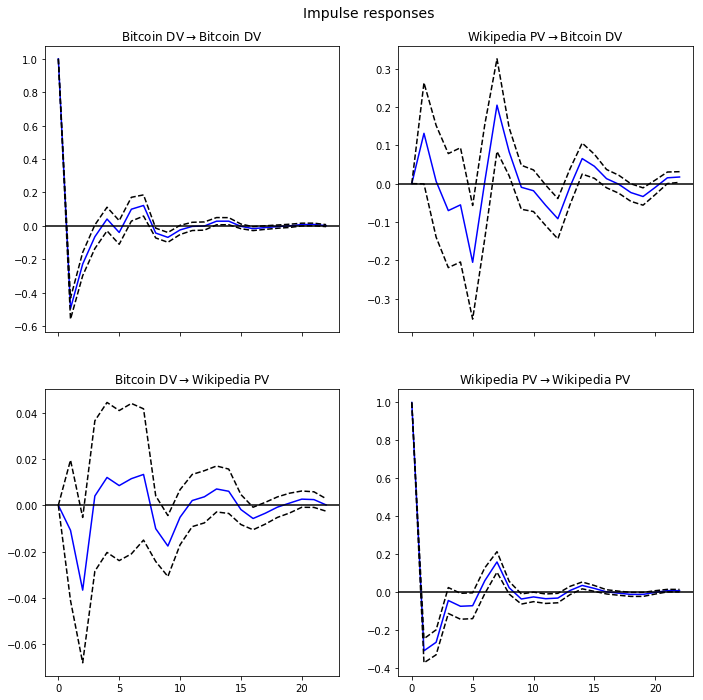

In [90]:
irf_2.plot()
plt.show()

With orthogonalization: Order: Bitcoin DV - Wikipedia PV

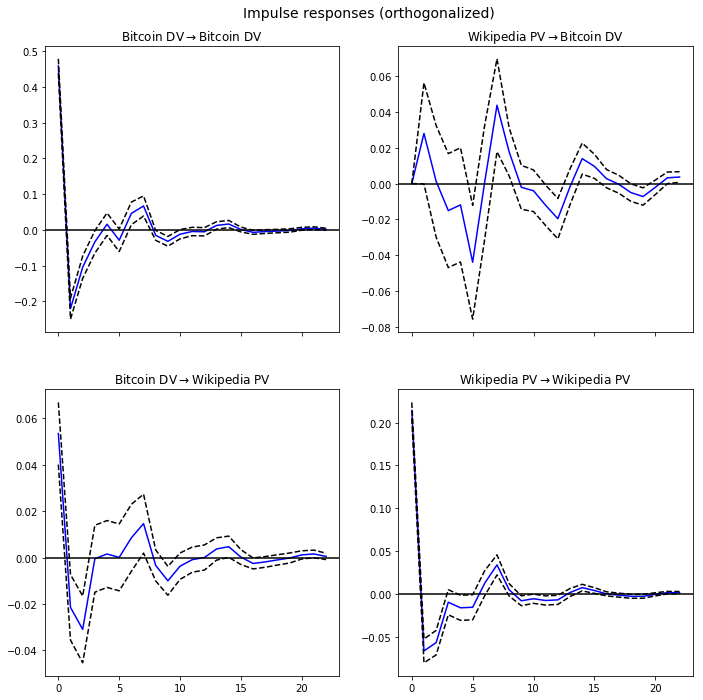

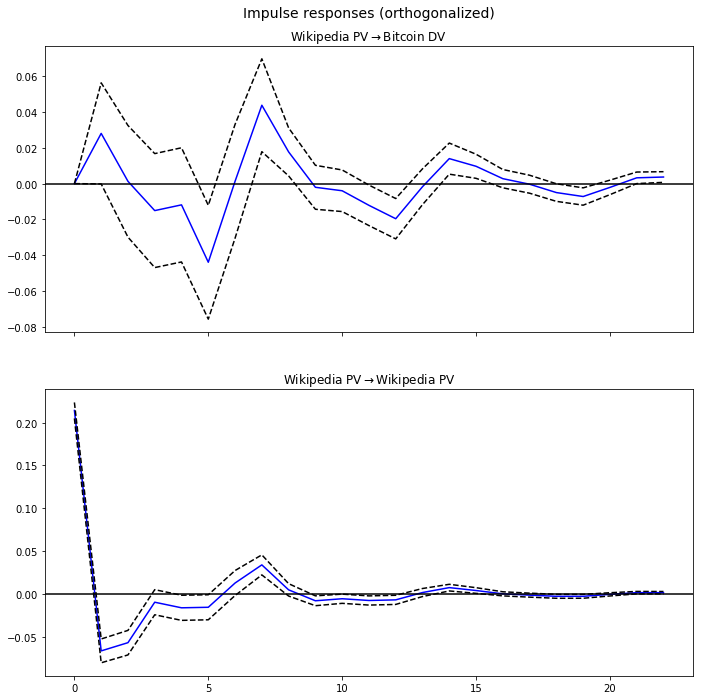

In [91]:
irf_2.plot(orth=True)
irf_2.plot(orth=True, impulse="Wikipedia PV")
plt.show()

With orthogonalisation: Order: Wikipedia PV - Bitcoin DV

In [92]:
cols_2 = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff.columns.tolist()
cols_2

['Bitcoin DV', 'Wikipedia PV']

In [93]:
cols_2 = cols_2[-1:] + cols_2[:-1]
cols_2

['Wikipedia PV', 'Bitcoin DV']

In [94]:
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff_b = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff[cols_2]
wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff_b.head()

,Wikipedia PV,Bitcoin DV
Date,,
2015-07-02,-0.279050,-0.309760
2015-07-03,-0.165488,-0.070958
2015-07-04,0.074220,-0.146065
2015-07-05,-0.028915,0.993533
2015-07-06,0.166142,-0.064518


In [95]:
data_2_b = wikipedia_pageviews_log_diff_and_bitcoin_volume_log_diff_b
model_2_b = VAR(data_2_b)

In [96]:
results_2_b = model_2_b.fit(maxlags=15, ic='bic')

In [97]:
results_2_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.48646
Nobs:                     1012.00    HQIC:                  -4.56484
Log likelihood:          -511.829    FPE:                 0.00992351
AIC:                     -4.61285    Det(Omega_mle):      0.00967339
--------------------------------------------------------------------
Results for equation Wikipedia PV
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000851         0.006937            0.123           0.902
L1.Wikipedia PV        -0.309494         0.032331           -9.573           0.000
L1.Bitcoin DV          -0.010807         0.01

In [98]:
irf_2_b = results_2_b.irf(22)

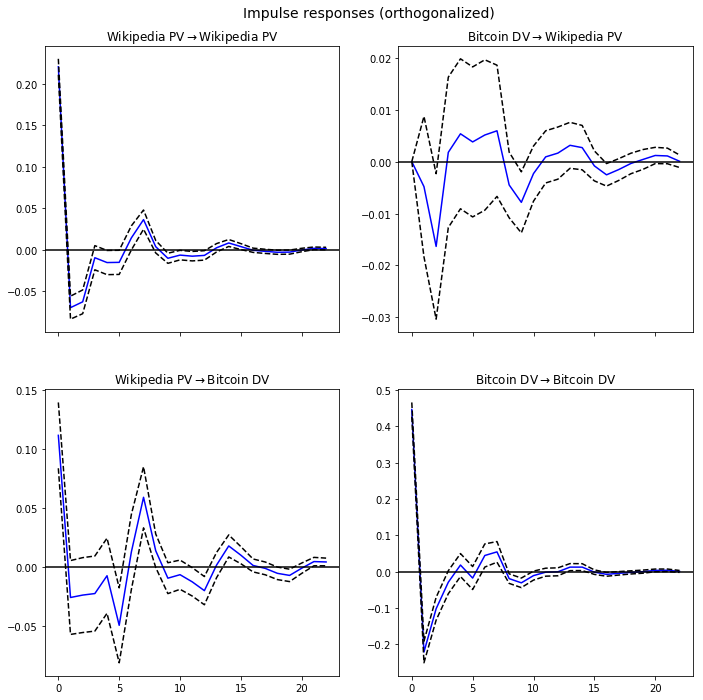

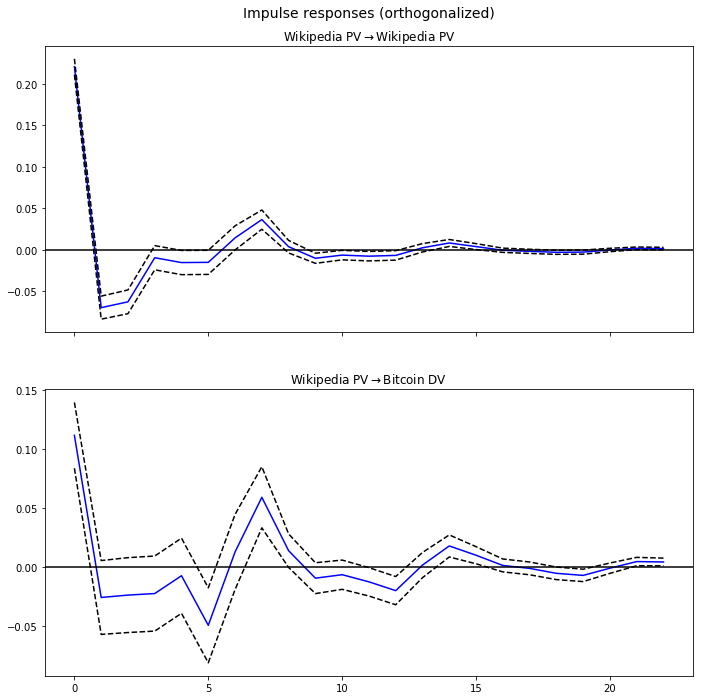

In [99]:
irf_2_b.plot(orth=True)
irf_2_b.plot(orth=True, impulse="Wikipedia PV")
plt.show()

## Granger Causality Test

In [100]:
results_2.test_causality("Bitcoin DV", "Wikipedia PV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         3.592432         2.103115            0.002  (6, 1998)
H_0: ['Wikipedia PV'] do not Granger-cause Bitcoin DV
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.0015157394998783242,
 'signif': 0.05,
 'statistic': 3.5924322875556025}

In [101]:
results_2.test_causality("Wikipedia PV", "Bitcoin DV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.488300         2.103115            0.178  (6, 1998)
H_0: ['Bitcoin DV'] do not Granger-cause Wikipedia PV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.17819565987059005,
 'signif': 0.05,
 'statistic': 1.4882995829157508}


## 5. Control Variable: Google SV Worldwide and Bitcoin WAV in USD

Import used data:

In [102]:
bitcoin_weekly_volume = pd.DataFrame.from_csv("Bitcoin Weekly Volume Data USD.csv")
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume Worldwide.csv")

## Calculate first log differences

In [103]:
bitcoin_weekly_volume_series = pd.Series(data=bitcoin_weekly_volume["Average Volume per Week"])
bitcoin_weekly_volume_series.head()

0    1.815588e+06
1    1.770383e+06
2    1.770067e+06
3    1.154001e+06
4    8.223102e+05
Name: Average Volume per Week, dtype: float64

In [104]:
bitcoin_weekly_volume_series_log = bitcoin_weekly_volume_series.apply(np.log)
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log.diff()
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log_diff.drop(0)
bitcoin_weekly_volume_series_log_diff.head()

1   -0.025213
2   -0.000179
3   -0.427782
4   -0.338873
5    0.033076
Name: Average Volume per Week, dtype: float64

In [105]:
google_queries_series = pd.Series(data=google_queries["Relative Search Volume Worldwide"])
google_queries_series.head()

0    6
1    3
2    3
3    3
4    2
Name: Relative Search Volume Worldwide, dtype: int64

In [106]:
google_queries_series_log = google_queries_series.apply(np.log)
google_queries_series_log_diff = google_queries_series_log.diff()
google_queries_series_log_diff = google_queries_series_log_diff.drop(0)
google_queries_series_log_diff.head()

1   -0.693147
2    0.000000
3    0.000000
4   -0.405465
5    0.000000
Name: Relative Search Volume Worldwide, dtype: float64

Join the two dataframes:

In [107]:
a = {'Date': bitcoin_weekly_volume["Date"] , 'Bitcoin WAV (USD)': bitcoin_weekly_volume_series_log_diff, "Google SV (Worldwide)" : google_queries_series_log_diff}

In [108]:
google_queries_log_diff_and_bitcoin_volume_log_diff = pd.DataFrame(a)
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.drop(0)
google_queries_log_diff_and_bitcoin_volume_log_diff["Date"] = pd.to_datetime(google_queries_log_diff_and_bitcoin_volume_log_diff["Date"])
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.set_index("Date")
google_queries_log_diff_and_bitcoin_volume_log_diff.head()

,Bitcoin WAV (USD),Google SV (Worldwide)
Date,,
2013-04-21,-0.025213,-0.693147
2013-04-28,-0.000179,0.000000
2013-05-05,-0.427782,0.000000
2013-05-12,-0.338873,-0.405465
2013-05-19,0.033076,0.000000


## Create the VAR Model

In [109]:
data_1 = google_queries_log_diff_and_bitcoin_volume_log_diff

In [110]:
model_1 = VAR(data_1)

## Lag order selection

In [111]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -4.634       -4.605     0.009720       -4.622
1        -4.767      -4.681*     0.008506      -4.732*
2        -4.764       -4.621     0.008534       -4.706
3       -4.782*       -4.582    0.008381*       -4.701
4        -4.780       -4.523     0.008397       -4.676
5        -4.763       -4.449     0.008539       -4.637
6        -4.761       -4.389     0.008560       -4.611
7        -4.769       -4.341     0.008488       -4.597
8        -4.748       -4.262     0.008671       -4.553
9        -4.737       -4.194     0.008770       -4.518
10       -4.715       -4.115     0.008965       -4.474
11       -4.701       -4.044     0.009095       -4.436
12       -4.680       -3.965     0.009297       -4.392
13       -4.653       -3.881     0.009553       -4.342
14       -4.642       -3.814     0.009655       -4.309
15       -

{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 1}

In [112]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

Check coefficients, contemporaneous correlation of residuals etc.

In [113]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:42:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.66096
Nobs:                     259.000    HQIC:                  -4.71022
Log likelihood:          -114.746    FPE:                 0.00870941
AIC:                     -4.74335    Det(Omega_mle):      0.00851110
--------------------------------------------------------------------
Results for equation Bitcoin WAV (USD)
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.018500         0.027140            0.682           0.496
L1.Bitcoin WAV (USD)            -0.330402         0.067805           -4.873           0.000
L1.G

## Impulse Response Analysis

In [114]:
irf_1 = results_1.irf(5)

Without orthogonalization:

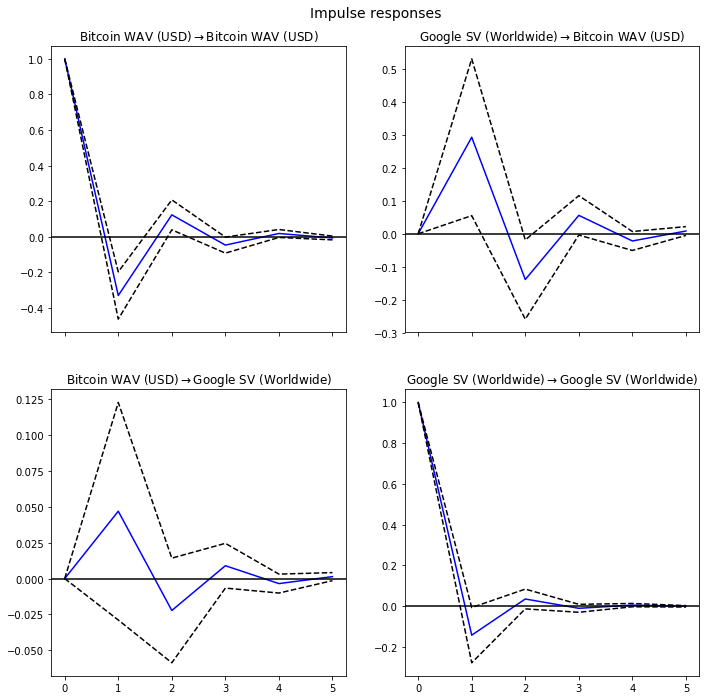

In [115]:
irf_1.plot()
plt.show()

With orthogonalization: Order: Bitcoin WAV - Google SV

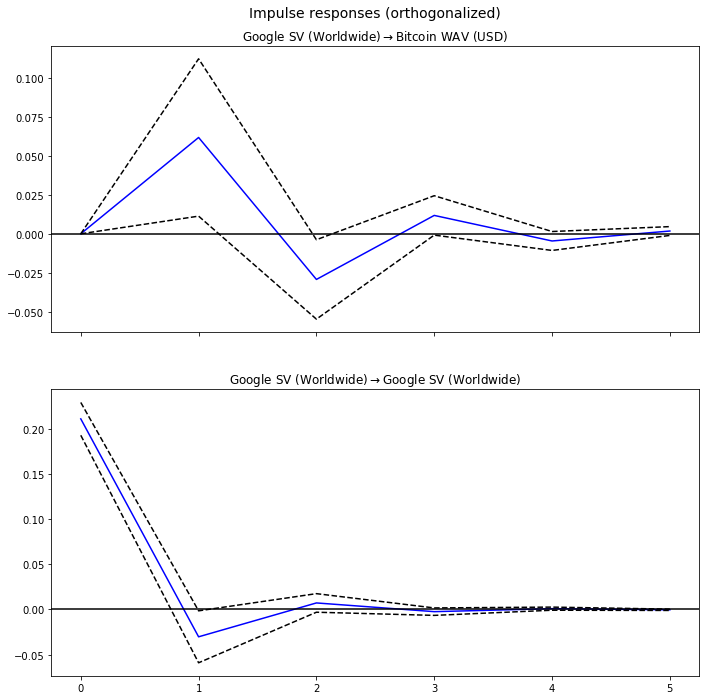

In [116]:
irf_1.plot(orth=True, impulse= "Google SV (Worldwide)")
plt.show()

With orthogonalization: Order: Google SV - Bitcoin WAV

In [117]:
cols = google_queries_log_diff_and_bitcoin_volume_log_diff.columns.tolist()
cols

['Bitcoin WAV (USD)', 'Google SV (Worldwide)']

In [118]:
cols = cols[-1:] + cols[:-1]
cols

['Google SV (Worldwide)', 'Bitcoin WAV (USD)']

In [119]:
google_queries_log_diff_and_bitcoin_volume_log_diff_b = google_queries_log_diff_and_bitcoin_volume_log_diff[cols]
google_queries_log_diff_and_bitcoin_volume_log_diff_b.head()

,Google SV (Worldwide),Bitcoin WAV (USD)
Date,,
2013-04-21,-0.693147,-0.025213
2013-04-28,0.000000,-0.000179
2013-05-05,0.000000,-0.427782
2013-05-12,-0.405465,-0.338873
2013-05-19,0.000000,0.033076


In [120]:
data_1_b = google_queries_log_diff_and_bitcoin_volume_log_diff_b
model_1_b = VAR(data_1_b)

In [121]:
results_1_b = model_1_b.fit(maxlags=15, ic='bic')

In [122]:
results_1_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:43:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.66096
Nobs:                     259.000    HQIC:                  -4.71022
Log likelihood:          -114.746    FPE:                 0.00870941
AIC:                     -4.74335    Det(Omega_mle):      0.00851110
--------------------------------------------------------------------
Results for equation Google SV (Worldwide)
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.006332         0.015467            0.409           0.683
L1.Google SV (Worldwide)        -0.143395         0.069242           -2.071           0.039


In [123]:
irf_1_b = results_1_b.irf(5)

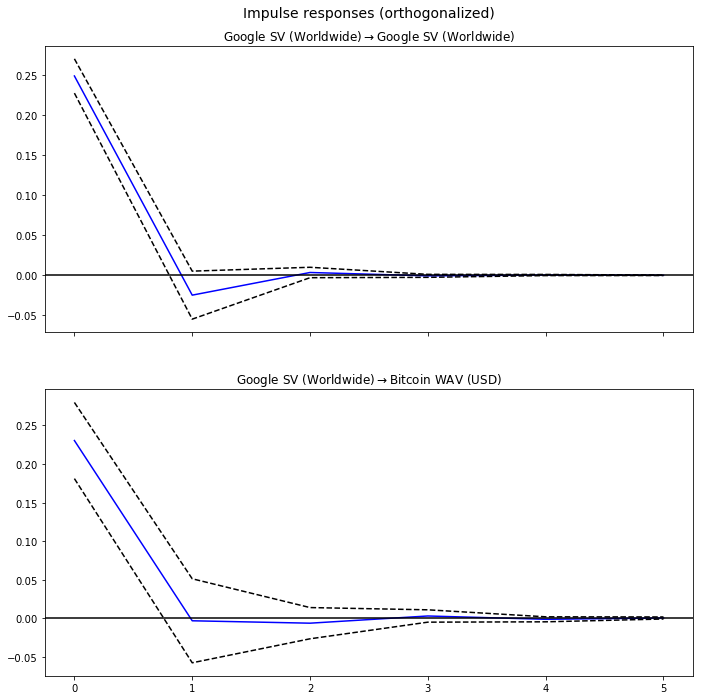

In [124]:
irf_1_b.plot(orth=True, impulse="Google SV (Worldwide)")
plt.show()

## Granger Causality Test

In [125]:
results_1.test_causality("Bitcoin WAV (USD)", "Google SV (Worldwide)", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         5.825179         3.859685            0.016  (1, 512)
H_0: ['Google SV (Worldwide)'] do not Granger-cause Bitcoin WAV (USD)
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.016148403775599007,
 'signif': 0.05,
 'statistic': 5.8251789411205168}

In [126]:
results_1.test_causality("Google SV (Worldwide)", "Bitcoin WAV (USD)", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         1.472387         3.859685            0.226  (1, 512)
H_0: ['Bitcoin WAV (USD)'] do not Granger-cause Google SV (Worldwide)
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.22552887318166662,
 'signif': 0.05,
 'statistic': 1.4723874000604551}


## 6. Control Variable: Google SV Worldwide and Bitcoin WAV in BTC

Import used data:

In [127]:
bitcoin_weekly_volume = pd.DataFrame.from_csv("Bitcoin Weekly Volume Data BTC.csv")
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume Worldwide.csv")

## Calculate first log differences

In [128]:
bitcoin_weekly_volume_series = pd.Series(data=bitcoin_weekly_volume["Average Volume per Week (BTC)"])
bitcoin_weekly_volume_series.head()

0    20202.562639
1    13204.207000
2    15670.144724
3    10198.091312
4     7279.517695
Name: Average Volume per Week (BTC), dtype: float64

In [129]:
bitcoin_weekly_volume_series_log = bitcoin_weekly_volume_series.apply(np.log)
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log.diff()
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log_diff.drop(0)
bitcoin_weekly_volume_series_log_diff.head()

1   -0.425274
2    0.171222
3   -0.429557
4   -0.337136
5   -0.042699
Name: Average Volume per Week (BTC), dtype: float64

In [130]:
google_queries_series = pd.Series(data=google_queries["Relative Search Volume Worldwide"])
google_queries_series.head()

0    6
1    3
2    3
3    3
4    2
Name: Relative Search Volume Worldwide, dtype: int64

In [131]:
google_queries_series_log = google_queries_series.apply(np.log)
google_queries_series_log_diff = google_queries_series_log.diff()
google_queries_series_log_diff = google_queries_series_log_diff.drop(0)
google_queries_series_log_diff.head()

1   -0.693147
2    0.000000
3    0.000000
4   -0.405465
5    0.000000
Name: Relative Search Volume Worldwide, dtype: float64

Join the two dataframes:

In [132]:
a = {'Date': bitcoin_weekly_volume["Date"] , 'Bitcoin WAV': bitcoin_weekly_volume_series_log_diff, "Google SV (Worldwide)" : google_queries_series_log_diff}

In [133]:
google_queries_log_diff_and_bitcoin_volume_log_diff = pd.DataFrame(a)
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.drop(0)
google_queries_log_diff_and_bitcoin_volume_log_diff["Date"] = pd.to_datetime(google_queries_log_diff_and_bitcoin_volume_log_diff["Date"])
google_queries_log_diff_and_bitcoin_volume_log_diff = google_queries_log_diff_and_bitcoin_volume_log_diff.set_index("Date")
google_queries_log_diff_and_bitcoin_volume_log_diff.head()

,Bitcoin WAV,Google SV (Worldwide)
Date,,
2013-04-21,-0.425274,-0.693147
2013-04-28,0.171222,0.000000
2013-05-05,-0.429557,0.000000
2013-05-12,-0.337136,-0.405465
2013-05-19,-0.042699,0.000000


## Create the VAR Model

In [134]:
data_1 = google_queries_log_diff_and_bitcoin_volume_log_diff

In [135]:
model_1 = VAR(data_1)

## Lag order selection

In [136]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -4.595       -4.567      0.01010       -4.584
1       -4.708*      -4.623*    0.009019*      -4.674*
2        -4.699       -4.556     0.009102       -4.642
3        -4.702       -4.502     0.009075       -4.622
4        -4.703       -4.445     0.009072       -4.599
5        -4.679       -4.364     0.009292       -4.552
6        -4.685       -4.314     0.009231       -4.536
7        -4.686       -4.258     0.009224       -4.514
8        -4.673       -4.187     0.009351       -4.477
9        -4.655       -4.112     0.009516       -4.437
10       -4.636       -4.035     0.009709       -4.394
11       -4.619       -3.962     0.009871       -4.355
12       -4.589       -3.875      0.01018       -4.301
13       -4.564       -3.792      0.01044       -4.253
14       -4.557       -3.728      0.01052       -4.223
15       -

{'aic': 1, 'bic': 1, 'fpe': 1, 'hqic': 1}

In [137]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

Check coefficients, contemporaneous correlation of residuals etc.

In [138]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:43:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.59456
Nobs:                     259.000    HQIC:                  -4.64383
Log likelihood:          -123.344    FPE:                 0.00930730
AIC:                     -4.67696    Det(Omega_mle):      0.00909538
--------------------------------------------------------------------
Results for equation Bitcoin WAV
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.002317         0.026767           -0.087           0.931
L1.Bitcoin WAV                  -0.354026         0.065738           -5.385           0.000
L1.Google 

## Impulse Response Analysis

In [139]:
irf_1 = results_1.irf(5)

Without orthogonalization:

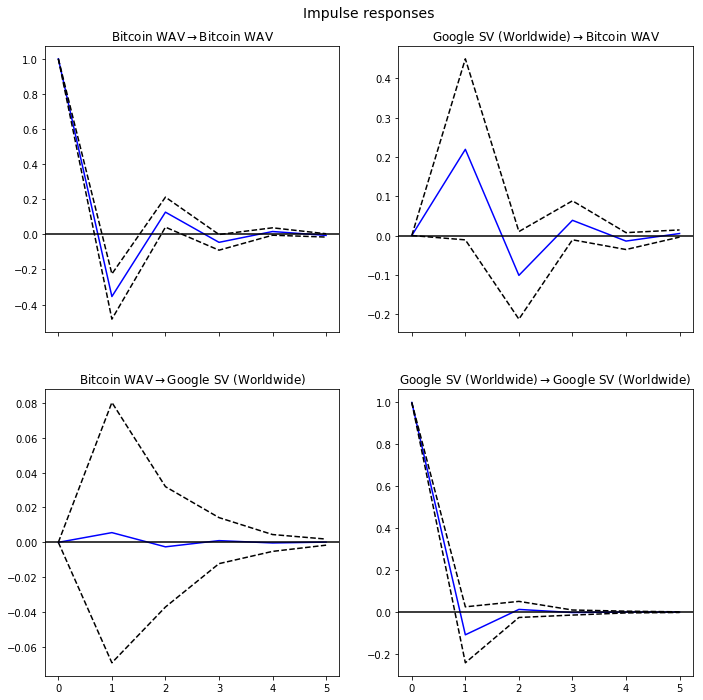

In [140]:
irf_1.plot()
plt.show()

With orthogonalization: Order: Bitcoin WAV - Google SV

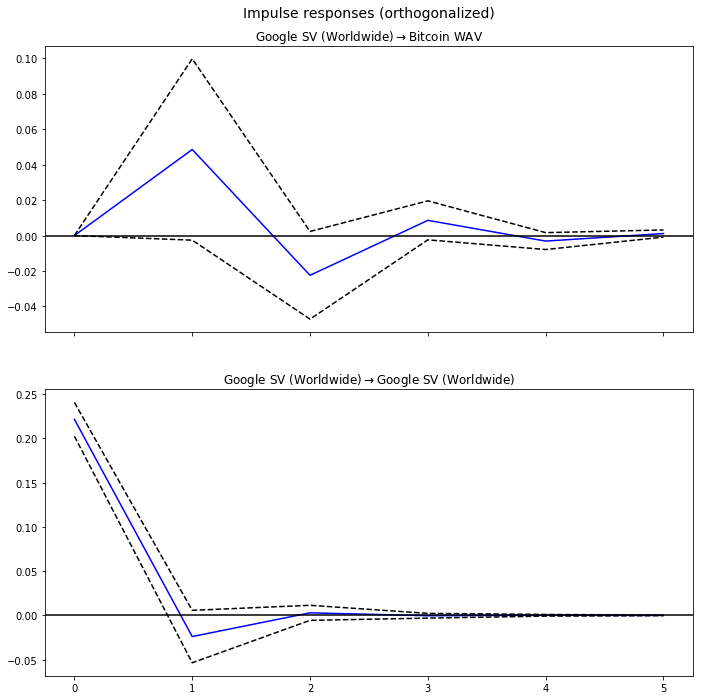

In [141]:
irf_1.plot(orth=True, impulse= "Google SV (Worldwide)")
plt.show()

With orthogonalization: Order: Google SV - Bitcoin WAV

In [142]:
cols = google_queries_log_diff_and_bitcoin_volume_log_diff.columns.tolist()
cols

['Bitcoin WAV', 'Google SV (Worldwide)']

In [143]:
cols = cols[-1:] + cols[:-1]
cols

['Google SV (Worldwide)', 'Bitcoin WAV']

In [144]:
google_queries_log_diff_and_bitcoin_volume_log_diff_b = google_queries_log_diff_and_bitcoin_volume_log_diff[cols]
google_queries_log_diff_and_bitcoin_volume_log_diff_b.head()

,Google SV (Worldwide),Bitcoin WAV
Date,,
2013-04-21,-0.693147,-0.425274
2013-04-28,0.000000,0.171222
2013-05-05,0.000000,-0.429557
2013-05-12,-0.405465,-0.337136
2013-05-19,0.000000,-0.042699


In [145]:
data_1_b = google_queries_log_diff_and_bitcoin_volume_log_diff_b
model_1_b = VAR(data_1_b)

In [146]:
results_1_b = model_1_b.fit(maxlags=15, ic='bic')

In [147]:
results_1_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:43:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.59456
Nobs:                     259.000    HQIC:                  -4.64383
Log likelihood:          -123.344    FPE:                 0.00930730
AIC:                     -4.67696    Det(Omega_mle):      0.00909538
--------------------------------------------------------------------
Results for equation Google SV (Worldwide)
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.006907         0.015505            0.445           0.656
L1.Google SV (Worldwide)        -0.108143         0.068084           -1.588           0.113


In [148]:
irf_1_b = results_1_b.irf(5)

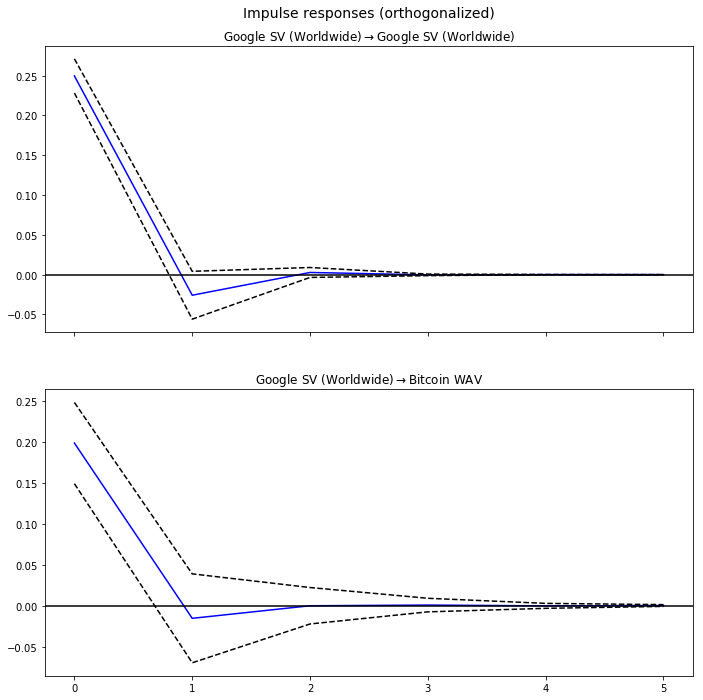

In [149]:
irf_1_b.plot(orth=True, impulse="Google SV (Worldwide)")
plt.show()

## Granger Causality Test

In [150]:
results_1.test_causality("Bitcoin WAV", "Google SV (Worldwide)", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         3.482318         3.859685            0.063  (1, 512)
H_0: ['Google SV (Worldwide)'] do not Granger-cause Bitcoin WAV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.062599341491265836,
 'signif': 0.05,
 'statistic': 3.4823175572451368}

In [151]:
results_1.test_causality("Google SV (Worldwide)", "Bitcoin WAV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.021435         3.859685            0.884  (1, 512)
H_0: ['Bitcoin WAV'] do not Granger-cause Google SV (Worldwide)
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.88365672196131817,
 'signif': 0.05,
 'statistic': 0.021435382982357299}